In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

# Basics

## Conversions

In [3]:
def kelvin_to_fahrenheit(kelvin):
    return (kelvin * 9/5) - 459.67

def fahrenheit_to_kelvin(f):
    return (f + 459.67) * 5/9

def kelvin_to_celsius(k):
    return k - 273.15

def celsius_to_kelvin(c):
    return c + 273.15

def fahrenheit_to_celsius(f):
    return (f - 32) * 5/9

def celsius_to_fahrenheit(c):
    return (c * 9/5) + 32

## Data creation

In [5]:
tas = np.array(range(290,332,2))
rh = np.array([40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
td = []
es = []

for t, r in zip(tas, rh):
    t = kelvin_to_celsius(t)
    td_data = t - ((100 - r) / 5)
    td.append(celsius_to_kelvin(td_data))

for dew_point in td:
    dew_point = kelvin_to_celsius(dew_point)
    es_data = (0.6108 * np.exp(17.27 * dew_point / (237.3 + dew_point)))
    es.append(es_data)

td = np.array(td)
es = np.array(es)

## Defining the algorithms

### 21 Algorithms (Anderson et al., 2013)

In [6]:
# Function to calculate Heat Index (HI) using algorithm 1 above
def heat_index_1(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    A = -10.3 + 1.1 * tas + 0.047 * rh

    B = (
        -42.379 + 2.04901523 * tas + 10.14333127 * rh
        - 0.22475541 * tas * rh
        - 6.83783e-3 * tas ** 2 - 5.481717e-2 * rh ** 2
        + 1.22874e-3 * tas ** 2 * rh
        + 8.5282e-4 * tas * rh ** 2
        - 1.99e-6 * tas ** 2 * rh ** 2
    )

    data = np.where(tas <= 40, tas,
        np.where(A < 79, A,
            np.where((rh < 13) & (80 <= tas) & (tas <= 112),
                B - ((13 - rh) / 4) * ((17 - abs((tas - 95))) / 17) ** 0.5,
                np.where((rh > 85) & (80 <= tas) & (tas <= 87),
                    B + 0.02 * (rh - 85) * (87 - tas),
                    B
                )
            )
        )
    )

    # data = np.ma.masked_where(data < -10, data) # Masking values below -10
    return fahrenheit_to_kelvin(data)

# Function to calculate Heat Index (HI) using algorithm 2 above
def heat_index_2(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = tas - (1.0799 * (math.e ** (0.03755 * tas)) * (1 - (math.e ** (0.0801 * (td - 14)))))
    data = celsius_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 3 above
def heat_index_3(tas, td):
    tas = kelvin_to_fahrenheit(tas)
    td = kelvin_to_fahrenheit(td)
    data = (tas - 0.9971 * (math.e ** (0.02086 * tas))
        * (1 - (math.e ** (0.0445 * (td - 57.2))))
    )
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 4 above
def heat_index_4(tas, es):
    tas = kelvin_to_celsius(tas)
    data = (
        -1.3 + 0.92 * tas + 2.2 * es)
    data = celsius_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 5 above
def heat_index_5(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.379
        + 2.04901523 * tas
        + 10.14333127 * rh
        - 0.22475541 * tas * rh
        - (6.83783e-3) * tas ** 2
        - (5.481717e-2) * rh ** 2
        + (1.22874e-3) * tas ** 2 * rh
        + (8.5282e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = np.logical_or(tas <= 80, rh <= 40)
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data
    
# Function to calculate Heat Index (HI) using algorithm 6 above
def heat_index_6(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.379
        + 2.04901523 * tas
        + 10.14333127 * rh
        - 0.22475541 * tas * rh
        - (6.83783e-3) * tas ** 2
        - (5.481717e-2) * rh ** 2
        + (1.22874e-3) * tas ** 2 * rh
        + (8.5282e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = np.logical_or(tas < 80, rh < 40)
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 7 above
def heat_index_7(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.379
        + 2.04901523 * tas
        + 10.14333127 * rh
        - 0.22475541 * tas * rh
        - (6.83783e-3) * tas ** 2
        - (5.481717e-2) * rh ** 2
        + (1.22874e-3) * tas ** 2 * rh
        + (8.5282e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = np.logical_or(tas <= 78.8, rh <= 39)
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 8 above
def heat_index_8(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.4
        + 2.049 * tas
        + 10.14 * rh
        - 0.2248 * tas * rh
        - (6.838e-3) * tas ** 2
        - (5.482e-2) * rh ** 2
        + (1.229e-3) * tas ** 2 * rh
        + (8.528e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = tas < 79
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 9 above
def heat_index_9(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        16.923
        + 0.185212 * tas
        + 5.37941 * rh
        - 0.100254 * tas * rh
        + 9.4169e-3 * tas ** 2
        + 7.28898e-3 * rh ** 2
        + 3.45372e-4 * tas ** 2 * rh
        - 8.14971e-4 * tas * rh ** 2
        + 1.02102e-5 * tas ** 2 * rh ** 2
        - 3.8646e-5 * tas ** 3
        + 2.91583e-5 * rh ** 3
        + 1.42721e-6 * tas ** 3 * rh 
        + 1.97483e-7 * tas * rh ** 3
        - 2.18429e-8 * tas ** 3 * rh ** 2
        + 8.43296e-10 * tas ** 2 * rh ** 3
        - 4.81975e-11 * tas ** 3 * rh ** 3
        + 0.5
    )

    # Apply correction factor
    correction_mask = tas < 75
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 10 above
def heat_index_10(tas, rh):
    tas = kelvin_to_celsius(tas)
    data = (
        -8.784695
        + 1.161139411 * tas
        + 2.338549 * rh
        - 0.14611605 * tas * rh
        - 1.2308094e-2 * tas ** 2
        - 1.6424828e-2 * rh ** 2
        + 2.211732e-3 * tas ** 2 * rh
        + 7.2546e-4 * tas * rh ** 2
        - 3.582e-6 * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = tas <= 20
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = celsius_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 11 above
def heat_index_11(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.4
        + 2.05 * tas
        + 10.1 * rh
        - 0.255 * tas * rh
        - (6.84e-3) * tas ** 2
        - (5.48e-2) * rh ** 2
        + (1.23e-3) * tas ** 2 * rh
        + (8.53e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    
    correction_mask = np.logical_or(tas <= 80, rh <= 40)
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 12 above
def heat_index_12(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = (
        -2.719
        + 0.994 * tas
        + 0.016 * td ** 2
    )

    # Apply correction factor
    correction_mask = tas < 25
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = celsius_to_kelvin(data)

    return data

# Function to calculate Heat Index (HI) using algorithm 13 above
def heat_index_13(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = (
        -2.653
        + 0.994 * tas
        + 0.0153 * td ** 2
    )
    data = celsius_to_kelvin(data)

    return data

# Function to calculate Heat Index (HI) using algorithm 14 above
def heat_index_14(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = (-2.719 
            + 0.994 * tas 
            + 0.016 * td ** 2)
    data = celsius_to_kelvin(data)

    return data

# Function to calculate Heat Index (HI) using algorithm 15 above
def heat_index_15(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.379
        + 2.049015 * tas
        + 10.1433 * rh
        - 0.2248 * tas * rh
        - (6.83783e-3) * tas ** 2
        - (5.4817e-2) * rh ** 2
        + (1.229e-3) * tas ** 2 * rh
        + (8.528e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )

    # Apply correction factor
    correction_mask = tas < 57
    if correction_mask.ndim > 0:
        data[correction_mask] = tas[correction_mask]
    else:
        if correction_mask:
            data = tas
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 16 above
def heat_index_16(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (
        -42.379
        + 2.04901523 * tas
        + 10.14333127 * rh
        - 0.22475541 * tas * rh
        - (6.83783e-3) * tas ** 2
        - (5.481717e-2) * rh ** 2
        + (1.22874e-3) * tas ** 2 * rh
        + (8.5282e-4) * tas * rh ** 2
        - (1.99e-6) * tas ** 2 * rh ** 2
    )
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 17 above
def heat_index_17(tas, rh):
    tas = kelvin_to_celsius(tas)
    data = (
        -8.7847 
        + 1.6114 * tas 
        - 0.012308 * tas ** 2
        + (rh * (2.3385 - 0.14612 * tas 
                           + 2.2117e-3 * tas ** 2))
        + (rh ** 2 * (-0.016425 + 7.2546e-4 * tas))
        + (-3.582e-6) * tas ** 2)
    data = celsius_to_kelvin(data)

    return data

# Function to calculate Heat Index (HI) using algorithm 18 above
def heat_index_18(tas, rh):
    tas = kelvin_to_celsius(tas)
    tas = (tas * 5/9) + 32
    data = (tas 
                          - 0.55 * (1 - 0.001 * rh) 
                          * (tas - 14.5))
    data = celsius_to_kelvin(data)

    return data

# Function to calculate Heat Index (HI) using algorithm 19 above
def heat_index_19(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = (2.719 
            + (0.994 * tas) 
            + (0.016 * (td ** 2)))
    data = celsius_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 20 above
def heat_index_20(tas, rh):
    tas = kelvin_to_fahrenheit(tas)
    data = (tas
           - ((0.55 - 0.55 * (rh / 100))
              * tas - 58)
    )
    data = fahrenheit_to_kelvin(data)
    return data

# Function to calculate Heat Index (HI) using algorithm 21 above
def heat_index_21(tas, td):
    tas = kelvin_to_celsius(tas)
    td = kelvin_to_celsius(td)
    data = (
        -2.653 
        + 0.994 * tas
        + 0.368 * (td ** 2)
    )
    data = celsius_to_kelvin(data)
    return data

### Lu and Romps

In [7]:
# Version 1.1 released by Yi-Chuan Lu on February 23, 2023.
#    Release 1.1 accommodates old Python 2 installations that
#    interpret some constants as integers instead of reals.
# Version 1.0 released by Yi-Chuan Lu on May 18, 2022.
# 
# When using this code, please cite:
# 
# @article{20heatindex,
#   Title   = {Extending the Heat Index},
#   Author  = {Yi-Chuan Lu and David M. Romps},
#   Journal = {Journal of Applied Meteorology and Climatology},
#   Year    = {2022},
#   Volume  = {61},
#   Number  = {10},
#   Pages   = {1367--1383},
#   Year    = {2022},
# }
#
# This headindex function returns the Heat Index in Kelvin. The inputs are:
# - T, the temperature in Kelvin
# - RH, the relative humidity, which is a value from 0 to 1
# - show_info is an optional logical flag. If true, the function returns the physiological state.

# Thermodynamic parameters
Ttrip = 273.16       # K
ptrip = 611.65       # Pa
E0v   = 2.3740e6     # J/kg
E0s   = 0.3337e6     # J/kg
rgasa = 287.04       # J/kg/K 
rgasv = 461.         # J/kg/K 
cva   = 719.         # J/kg/K
cvv   = 1418.        # J/kg/K 
cvl   = 4119.        # J/kg/K
cvs   = 1861.        # J/kg/K
cpa   = cva + rgasa
cpv   = cvv + rgasv

# The saturation vapor pressure
def pvstar(T):
    if T == 0.0:
        return 0.0
    elif T<Ttrip:
        return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) * math.exp( (E0v + E0s -(cvv-cvs)*Ttrip)/rgasv * (1./Ttrip - 1./T) )
    else:
        return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * math.exp( (E0v       -(cvv-cvl)*Ttrip)/rgasv * (1./Ttrip - 1./T) )

# The latent heat of vaporization of water
def Le(T):
    return (E0v + (cvv-cvl)*(T-Ttrip) + rgasv*T)

# Thermoregulatory parameters
sigma       = 5.67e-8                     # W/m^2/K^4 , Stefan-Boltzmann constant
epsilon     = 0.97                        #           , emissivity of surface, steadman1979
M           = 83.6                        # kg        , mass of average US adults, fryar2018
H           = 1.69                        # m         , height of average US adults, fryar2018
A           = 0.202*(M**0.425)*(H**0.725) # m^2       , DuBois formula, parson2014
cpc         = 3492.                       # J/kg/K    , specific heat capacity of core, gagge1972
C           = M*cpc/A                     #           , heat capacity of core
r           = 124.                        # Pa/K      , Zf/Rf, steadman1979
Q           = 180.                        # W/m^2     , metabolic rate per skin area, steadman1979
phi_salt    = 0.9                         #           , vapor saturation pressure level of saline solution, steadman1979
Tc          = 310.                        # K         , core temperature, steadman1979
Pc          = phi_salt * pvstar(Tc)       #           , core vapor pressure
L           = Le(310.)                    #           , latent heat of vaporization at 310 K
p           = 1.013e5                     # Pa        , atmospheric pressure
eta         = 1.43e-6                     # kg/J      , "inhaled mass" / "metabolic rate", steadman1979
Pa0         = 1.6e3                       # Pa        , reference air vapor pressure in regions III, IV, V, VI, steadman1979

# Thermoregulatory functions
def Qv(Ta,Pa): # respiratory heat loss, W/m^2
    return  eta * Q *(cpa*(Tc-Ta)+L*rgasa/(p*rgasv) * ( Pc-Pa ) )
def Zs(Rs): # mass transfer resistance through skin, Pa m^2/W
    return (52.1 if Rs == 0.0387 else 6.0e8 * Rs**5)
def Ra(Ts,Ta): # heat transfer resistance through air, exposed part of skin, K m^2/W
    hc      = 17.4
    phi_rad = 0.85
    hr      = epsilon * phi_rad * sigma* (Ts**2 + Ta**2)*(Ts + Ta)
    return 1./(hc+hr)
def Ra_bar(Tf,Ta): # heat transfer resistance through air, clothed part of skin, K m^2/W
    hc      = 11.6
    phi_rad = 0.79
    hr      = epsilon * phi_rad * sigma* (Tf**2 + Ta**2)*(Tf + Ta)
    return 1./(hc+hr)
def Ra_un(Ts,Ta): # heat transfer resistance through air, when being naked, K m^2/W
    hc      = 12.3
    phi_rad = 0.80
    hr      = epsilon * phi_rad * sigma* (Ts**2 + Ta**2)*(Ts + Ta)
    return 1./(hc+hr)

Za     = 60.6/17.4  # Pa m^2/W, mass transfer resistance through air, exposed part of skin
Za_bar = 60.6/11.6  # Pa m^2/W, mass transfer resistance through air, clothed part of skin
Za_un  = 60.6/12.3  # Pa m^2/W, mass transfer resistance through air, when being naked

# tolerance and maximum iteration for the root solver 
tol     = 1e-8
tolT    = 1e-8
maxIter = 100

# Given air temperature and relative humidity, returns the equivalent variables 
def find_eqvar(Ta,RH):
    Pa    = RH*pvstar(Ta) #         , air vapor pressure
    Rs    = 0.0387        # m^2K/W  , heat transfer resistance through skin
    phi   = 0.84          #         , covering fraction
    dTcdt = 0.            # K/s     , rate of change in Tc
    m     = (Pc-Pa)/(Zs(Rs)+Za)
    m_bar = (Pc-Pa)/(Zs(Rs)+Za_bar)
    Ts = solve(lambda Ts: (Ts-Ta)/Ra(Ts,Ta)     + (Pc-Pa)/(Zs(Rs)+Za)     - (Tc-Ts)/Rs, max(0.,min(Tc,Ta)-Rs*abs(m)),     max(Tc,Ta)+Rs*abs(m),    tol,maxIter)
    Tf = solve(lambda Tf: (Tf-Ta)/Ra_bar(Tf,Ta) + (Pc-Pa)/(Zs(Rs)+Za_bar) - (Tc-Tf)/Rs, max(0.,min(Tc,Ta)-Rs*abs(m_bar)), max(Tc,Ta)+Rs*abs(m_bar),tol,maxIter)
    flux1 = Q-Qv(Ta,Pa)-(1.-phi)*(Tc-Ts)/Rs                   # C*dTc/dt when Rf=Zf=\inf
    flux2 = Q-Qv(Ta,Pa)-(1.-phi)*(Tc-Ts)/Rs - phi*(Tc-Tf)/Rs  # C*dTc/dt when Rf=Zf=0
    if (flux1 <= 0.) : # region I
        eqvar_name = "phi"
        phi = 1.-(Q-Qv(Ta,Pa))*Rs/(Tc-Ts)
        Rf  = float('inf')
    elif (flux2 <=0.) : # region II&III
        eqvar_name = "Rf"
        Ts_bar = Tc - (Q-Qv(Ta,Pa))*Rs/phi + (1./phi -1.)*(Tc-Ts)
        Tf = solve(lambda Tf: (Tf-Ta)/Ra_bar(Tf,Ta) + (Pc-Pa)*(Tf-Ta)/((Zs(Rs)+Za_bar)*(Tf-Ta)+r*Ra_bar(Tf,Ta)*(Ts_bar-Tf)) - (Tc-Ts_bar)/Rs, Ta,Ts_bar,tol,maxIter)
        Rf = Ra_bar(Tf,Ta)*(Ts_bar-Tf)/(Tf-Ta)
    else: # region IV,V,VI
        Rf = 0.
        flux3 =  Q-Qv(Ta,Pa)-(Tc-Ta)/Ra_un(Tc,Ta)-(phi_salt*pvstar(Tc)-Pa)/Za_un
        if (flux3 < 0.) : # region IV,V
            Ts = solve(lambda Ts: (Ts-Ta)/Ra_un(Ts,Ta)+(Pc-Pa)/(Zs((Tc-Ts)/(Q-Qv(Ta,Pa)))+Za_un)-(Q-Qv(Ta,Pa)),0.,Tc,tol,maxIter)
            Rs = (Tc-Ts)/(Q-Qv(Ta,Pa))
            eqvar_name = "Rs"
            Ps = Pc - (Pc-Pa)* Zs(Rs)/( Zs(Rs)+Za_un)
            if (Ps > phi_salt * pvstar(Ts)):  # region V
                Ts = solve( lambda Ts : (Ts-Ta)/Ra_un(Ts,Ta) + (phi_salt*pvstar(Ts)-Pa)/Za_un -(Q-Qv(Ta,Pa)), 0.,Tc,tol,maxIter)
                Rs = (Tc-Ts)/(Q-Qv(Ta,Pa))
                eqvar_name = "Rs*"
        else: # region VI
            Rs = 0.
            eqvar_name = "dTcdt"
            dTcdt = (1./C)* flux3
    return [eqvar_name,phi,Rf,Rs,dTcdt]

# given the equivalent variable, find the Heat Index
def find_T(eqvar_name,eqvar):
    if (eqvar_name == "phi"):
        T = solve(lambda T: find_eqvar(T,1.)[1]-eqvar,0.,240.,tolT,maxIter)
        region = 'I'
    elif (eqvar_name == "Rf"):
        T = solve(lambda T: find_eqvar(T,min(1.,Pa0/pvstar(T)))[2]-eqvar,230.,300.,tolT,maxIter)
        region = ('II' if Pa0>pvstar(T) else 'III')
    elif (eqvar_name == "Rs" or eqvar_name == "Rs*"):
        T = solve(lambda T: find_eqvar(T,Pa0/pvstar(T))[3]-eqvar,295.,350.,tolT,maxIter)
        region = ('IV' if eqvar_name == "Rs" else 'V')
    else:
        T = solve(lambda T: find_eqvar(T,Pa0/pvstar(T))[4]-eqvar,340.,1000.,tolT,maxIter)
        region = 'VI'
    return T, region

# combining the two functions find_eqvar and find_T
def heatindex(Ta,RH,show_info=False):
    dic = {"phi":1,"Rf":2,"Rs":3,"Rs*":3,"dTcdt":4}
    eqvars = find_eqvar(Ta,RH)
    T, region = find_T(eqvars[0],eqvars[dic[eqvars[0]]])
    if (Ta == 0.): T = 0.
    if (show_info==True):
        if region=='I':
            print("Region I, covering (variable phi)")
            print("Clothing fraction is "+ str(round(eqvars[1],3)))
        elif region=='II':
            print("Region II, clothed (variable Rf, pa = pvstar)")
            print("Clothing thickness is "+ str(round((eqvars[2]/16.7)*100.,3))+" cm")
        elif region=='III':
            print("Region III, clothed (variable Rf, pa = pref)")
            print("Clothing thickness is "+ str(round((eqvars[2]/16.7)*100.,3))+" cm")
        elif region=='IV':
            kmin = 5.28               # W/K/m^2     , conductance of tissue
            rho  = 1.0e3              # kg/m^3      , density of blood
            c    = 4184.              # J/kg/K      , specific heat of blood
            print("Region IV, naked (variable Rs, ps < phisalt*pvstar)")
            print("Blood flow is " + str(round(( (1./eqvars[3] - kmin)*A/(rho*c) ) *1000.*60.,3))+" l/min")
        elif region=='V':
            kmin = 5.28               # W/K/m^2     , conductance of tissue
            rho  = 1.0e3              # kg/m^3      , density of blood
            c    = 4184.              # J/kg/K      , specific heat of blood
            print("Region V, naked dripping sweat (variable Rs, ps = phisalt*pvstar)")
            print("Blood flow is " + str(round(( (1./eqvars[3] - kmin)*A/(rho*c) ) *1000.*60.,3))+" l/min")
        else:
            print("Region VI, warming up (dTc/dt > 0)")
            print("dTc/dt = "+ str(round(eqvars[4]*3600.,6))+ " K/hour")
    return T

def solve(f,x1,x2,tol,maxIter):
    a  = x1
    b  = x2
    fa = f(a)
    fb = f(b)
    if fa*fb>0.:
        raise SystemExit('wrong initial interval in the root solver')
        return None
    else:
        for i in range(maxIter):
            c  = (a+b)/2.
            fc = f(c)
            if fb*fc > 0. :
                b  = c
                fb = fc
            else:
                a  = c
                fa = fc   
            if abs(a-b) < tol:
                return c
            if i == maxIter-1:
                raise SystemExit('reaching maximum iteration in the root solver')
                return None

# Plots

## Creating 3 figures; each with 7 of the subplots

Heat index lu and romps table created, saving as heat_index_tables/heat_index_lu_and_romps.csv


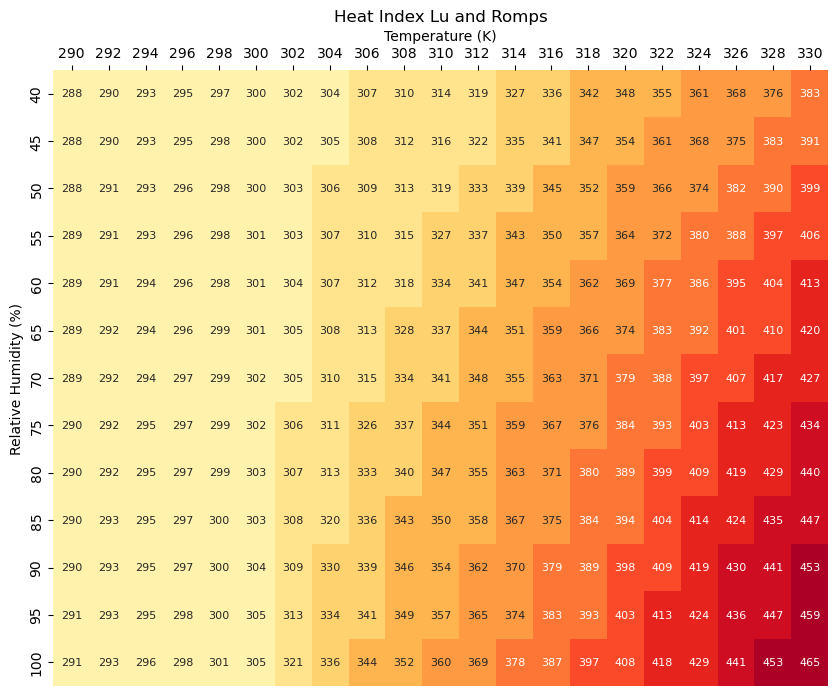

Creating heat index 1 table...
Heat index 1 table created, saving as heat_index_tables/heat_index_1.csv
Creating heat index 2 table...
Heat index 2 table created, saving as heat_index_tables/heat_index_2.csv


/var/folders/9v/9sz6tm8n0l7516_drc_ctgyw0000gn/T/ipykernel_37877/1098823624.py:18: RuntimeWarning: invalid value encountered in scalar power
  B - ((13 - rh) / 4) * ((17 - abs((tas - 95))) / 17) ** 0.5,


Creating heat index 3 table...
Heat index 3 table created, saving as heat_index_tables/heat_index_3.csv
Creating heat index 4 table...
Heat index 4 table created, saving as heat_index_tables/heat_index_4.csv
Creating heat index 5 table...
Heat index 5 table created, saving as heat_index_tables/heat_index_5.csv
Creating heat index 6 table...
Heat index 6 table created, saving as heat_index_tables/heat_index_6.csv
Creating heat index 7 table...
Heat index 7 table created, saving as heat_index_tables/heat_index_7.csv
Creating heat index 8 table...
Heat index 8 table created, saving as heat_index_tables/heat_index_8.csv
Creating heat index 9 table...
Heat index 9 table created, saving as heat_index_tables/heat_index_9.csv
Creating heat index 10 table...
Heat index 10 table created, saving as heat_index_tables/heat_index_10.csv
Creating heat index 11 table...
Heat index 11 table created, saving as heat_index_tables/heat_index_11.csv
Creating heat index 12 table...
Heat index 12 table create

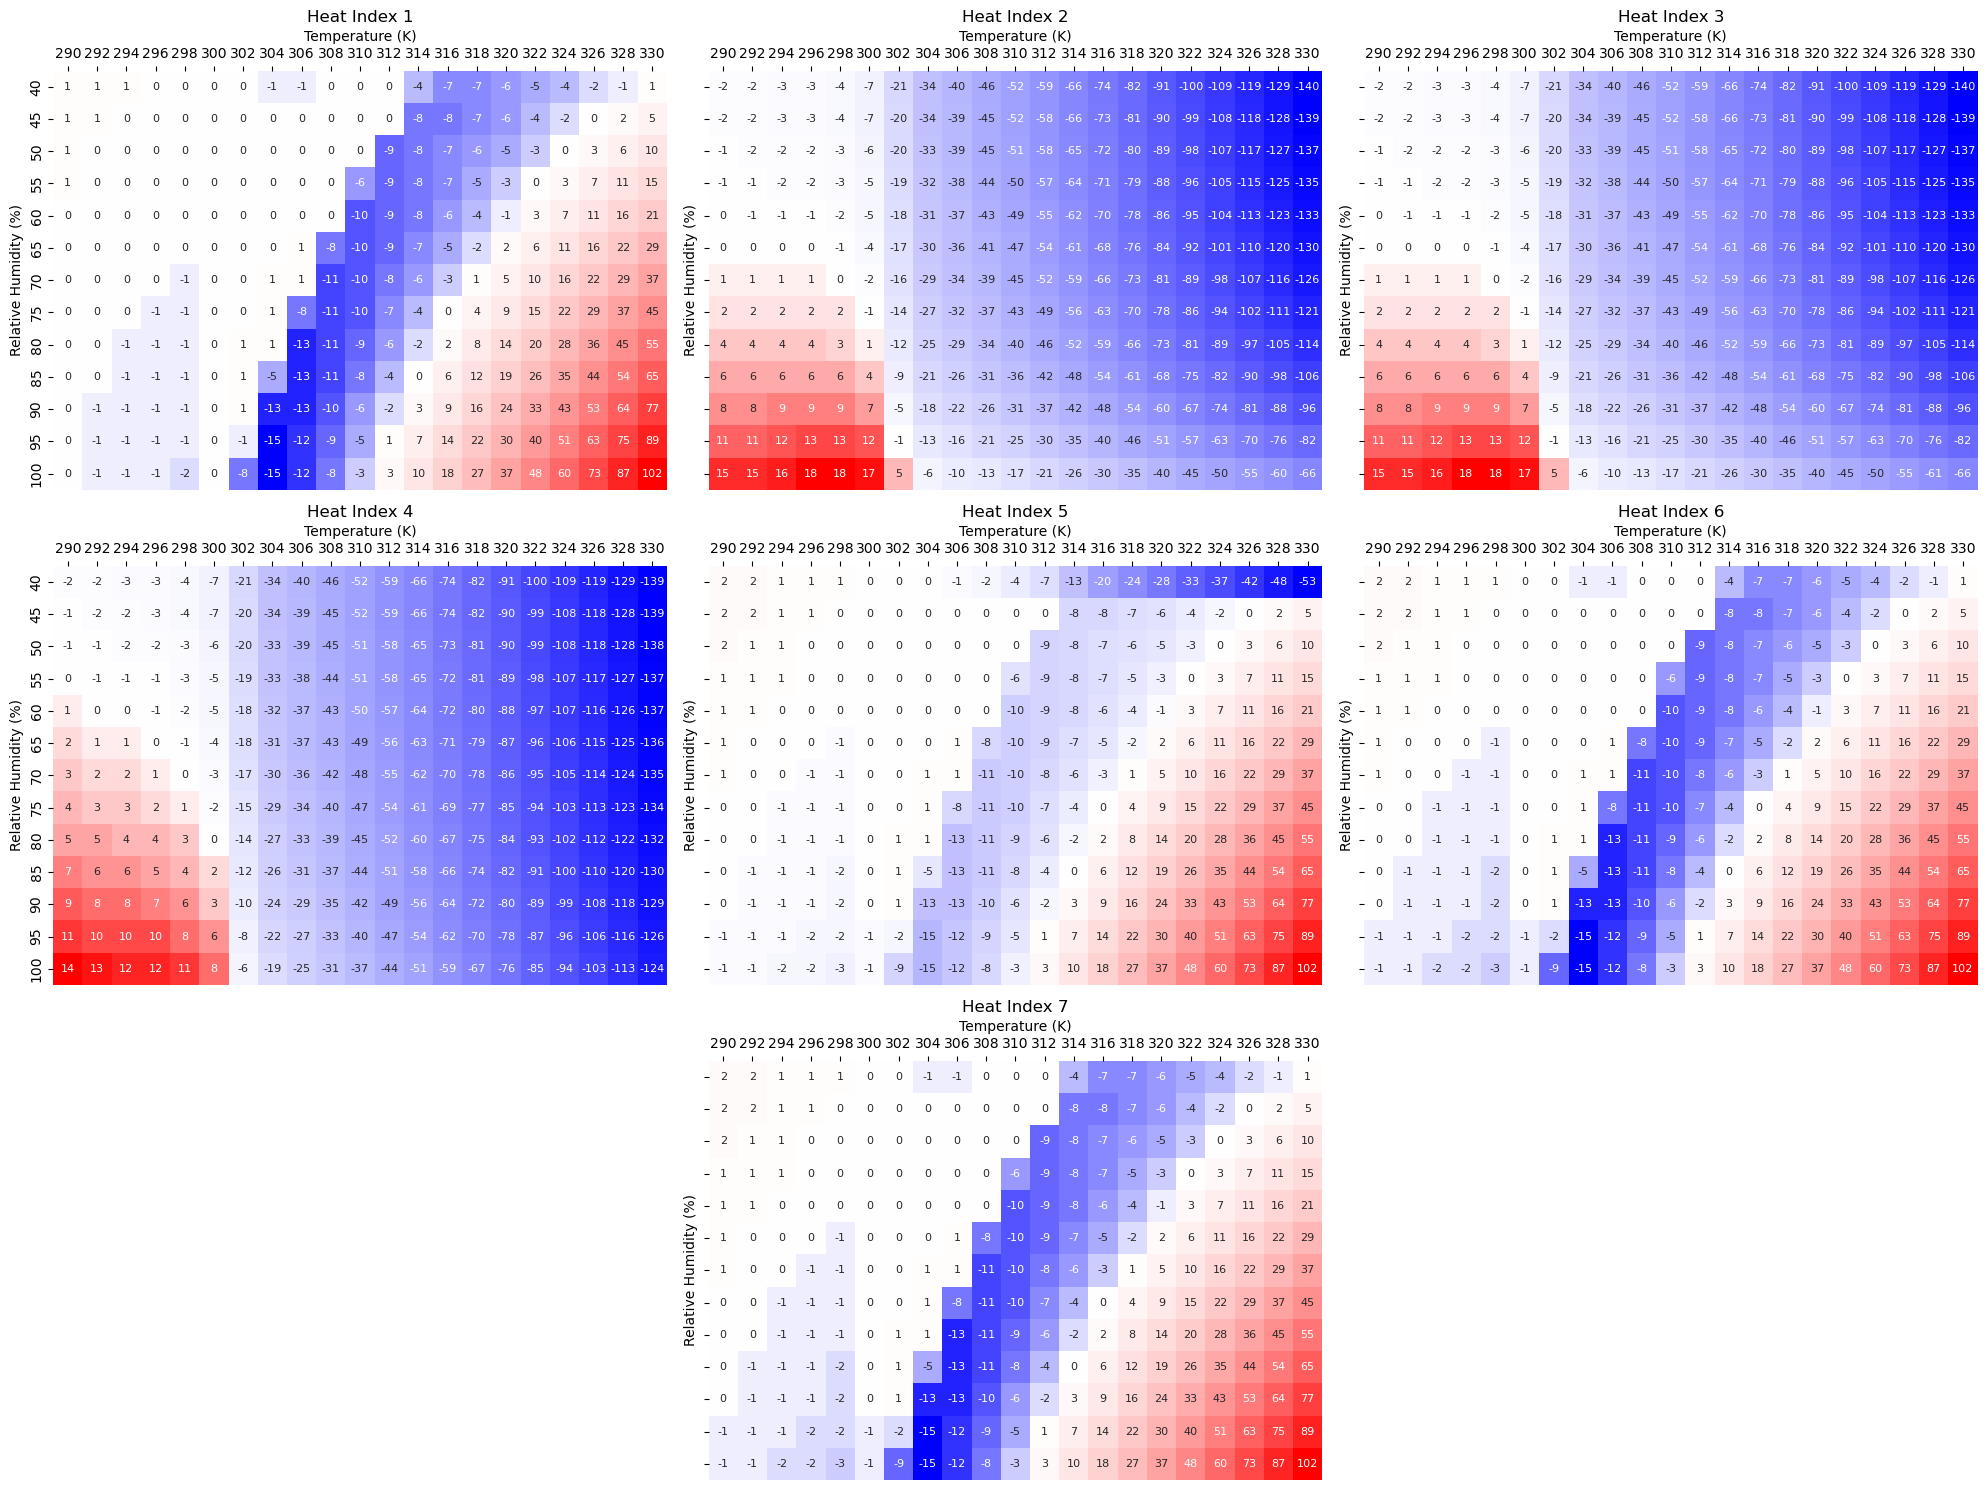

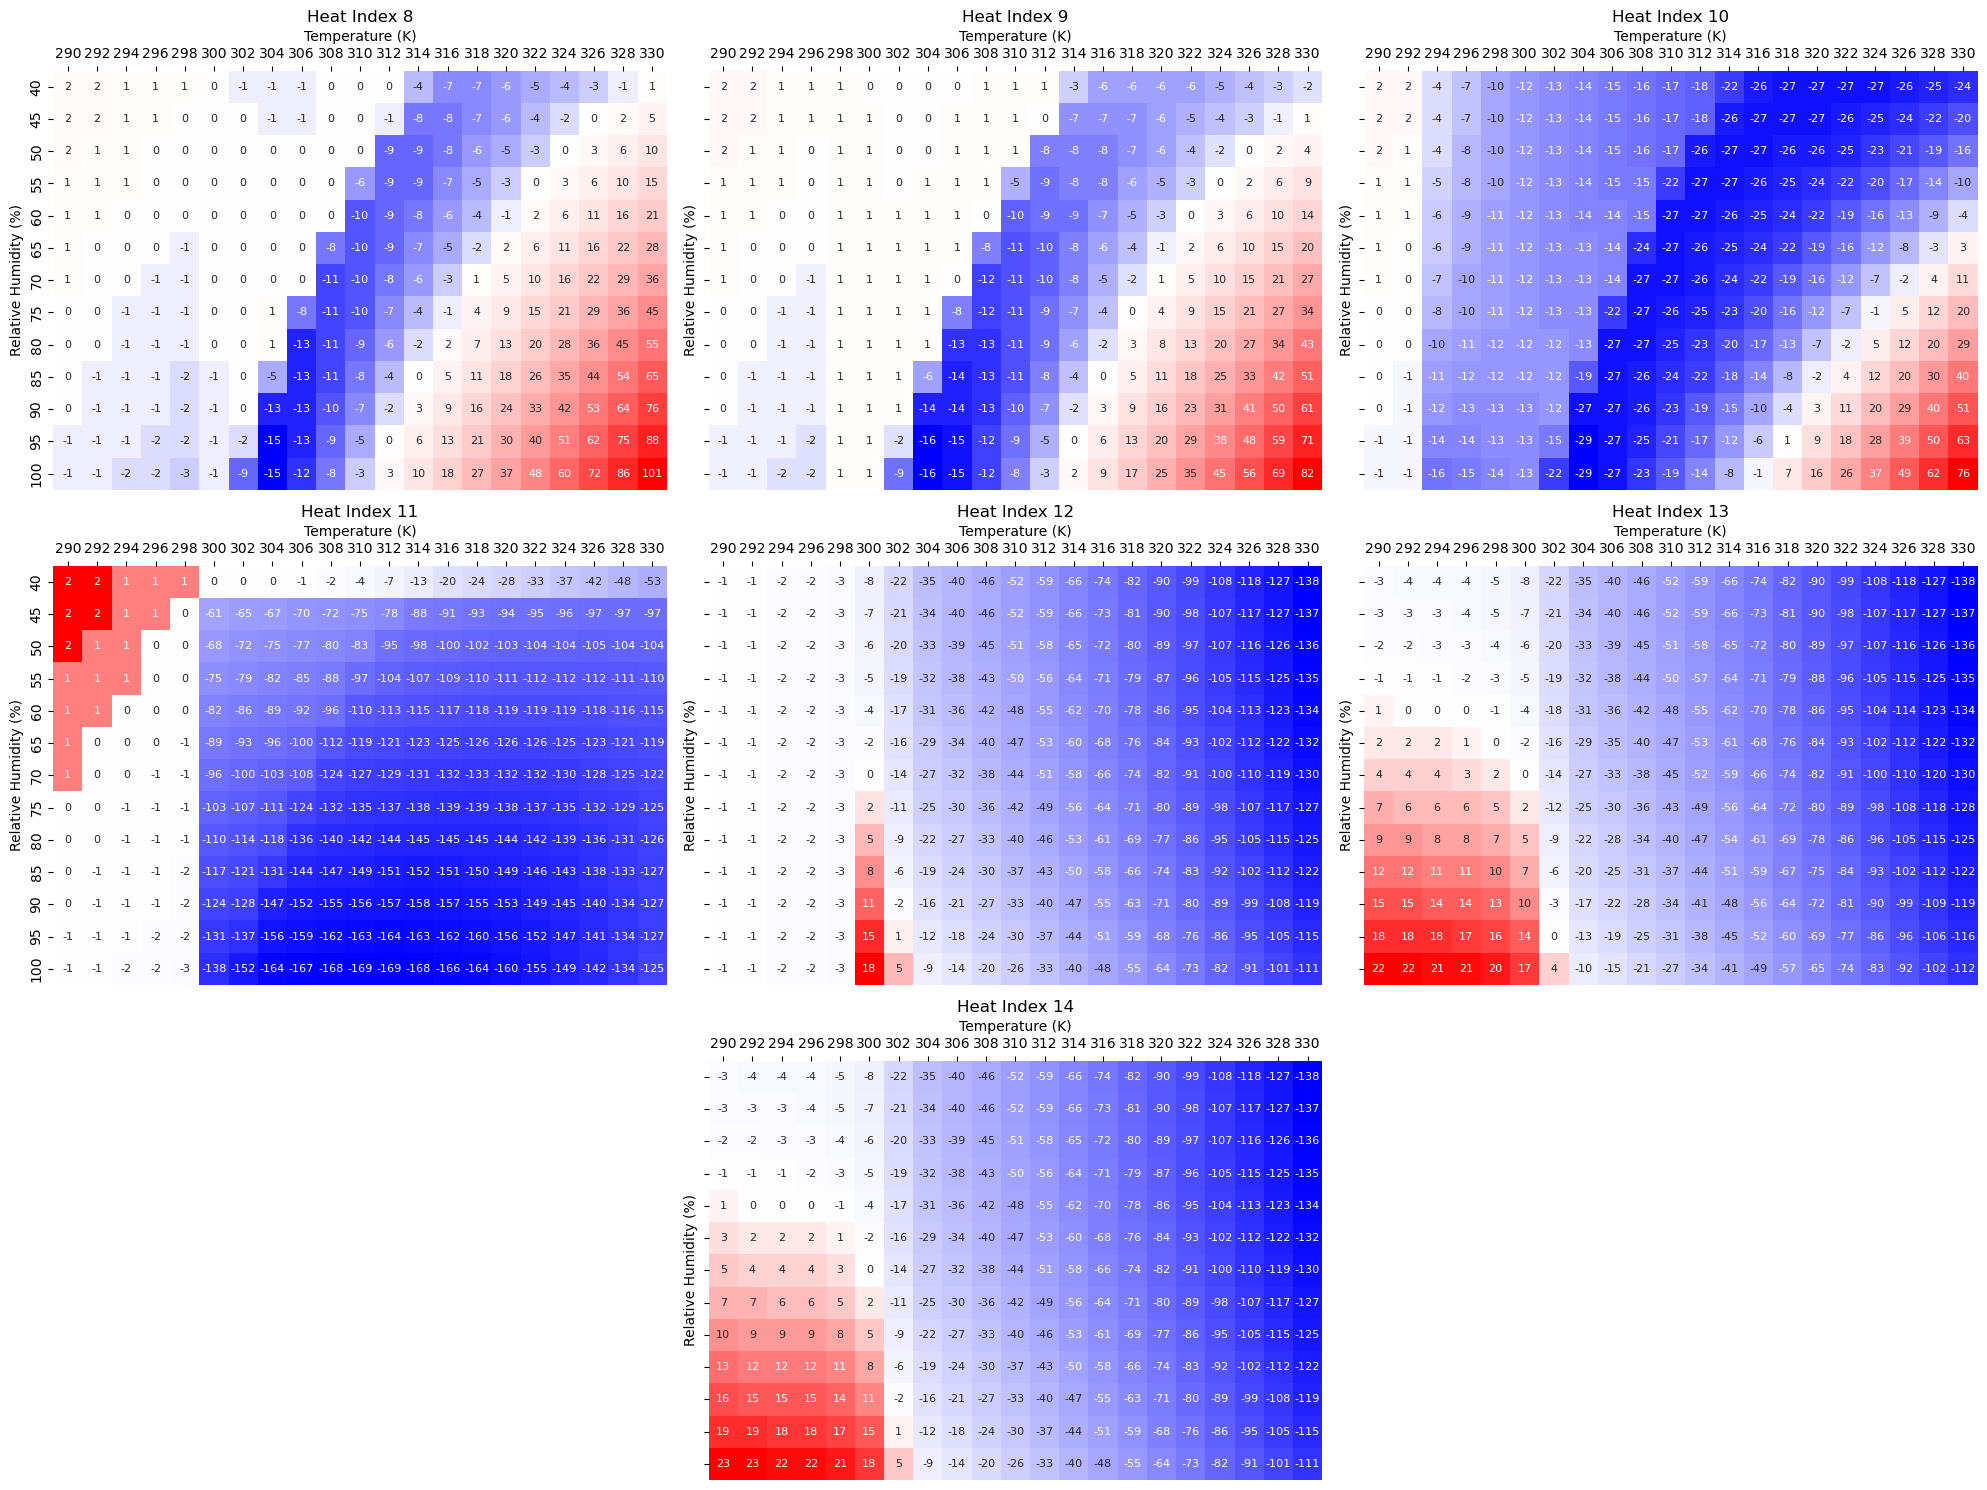

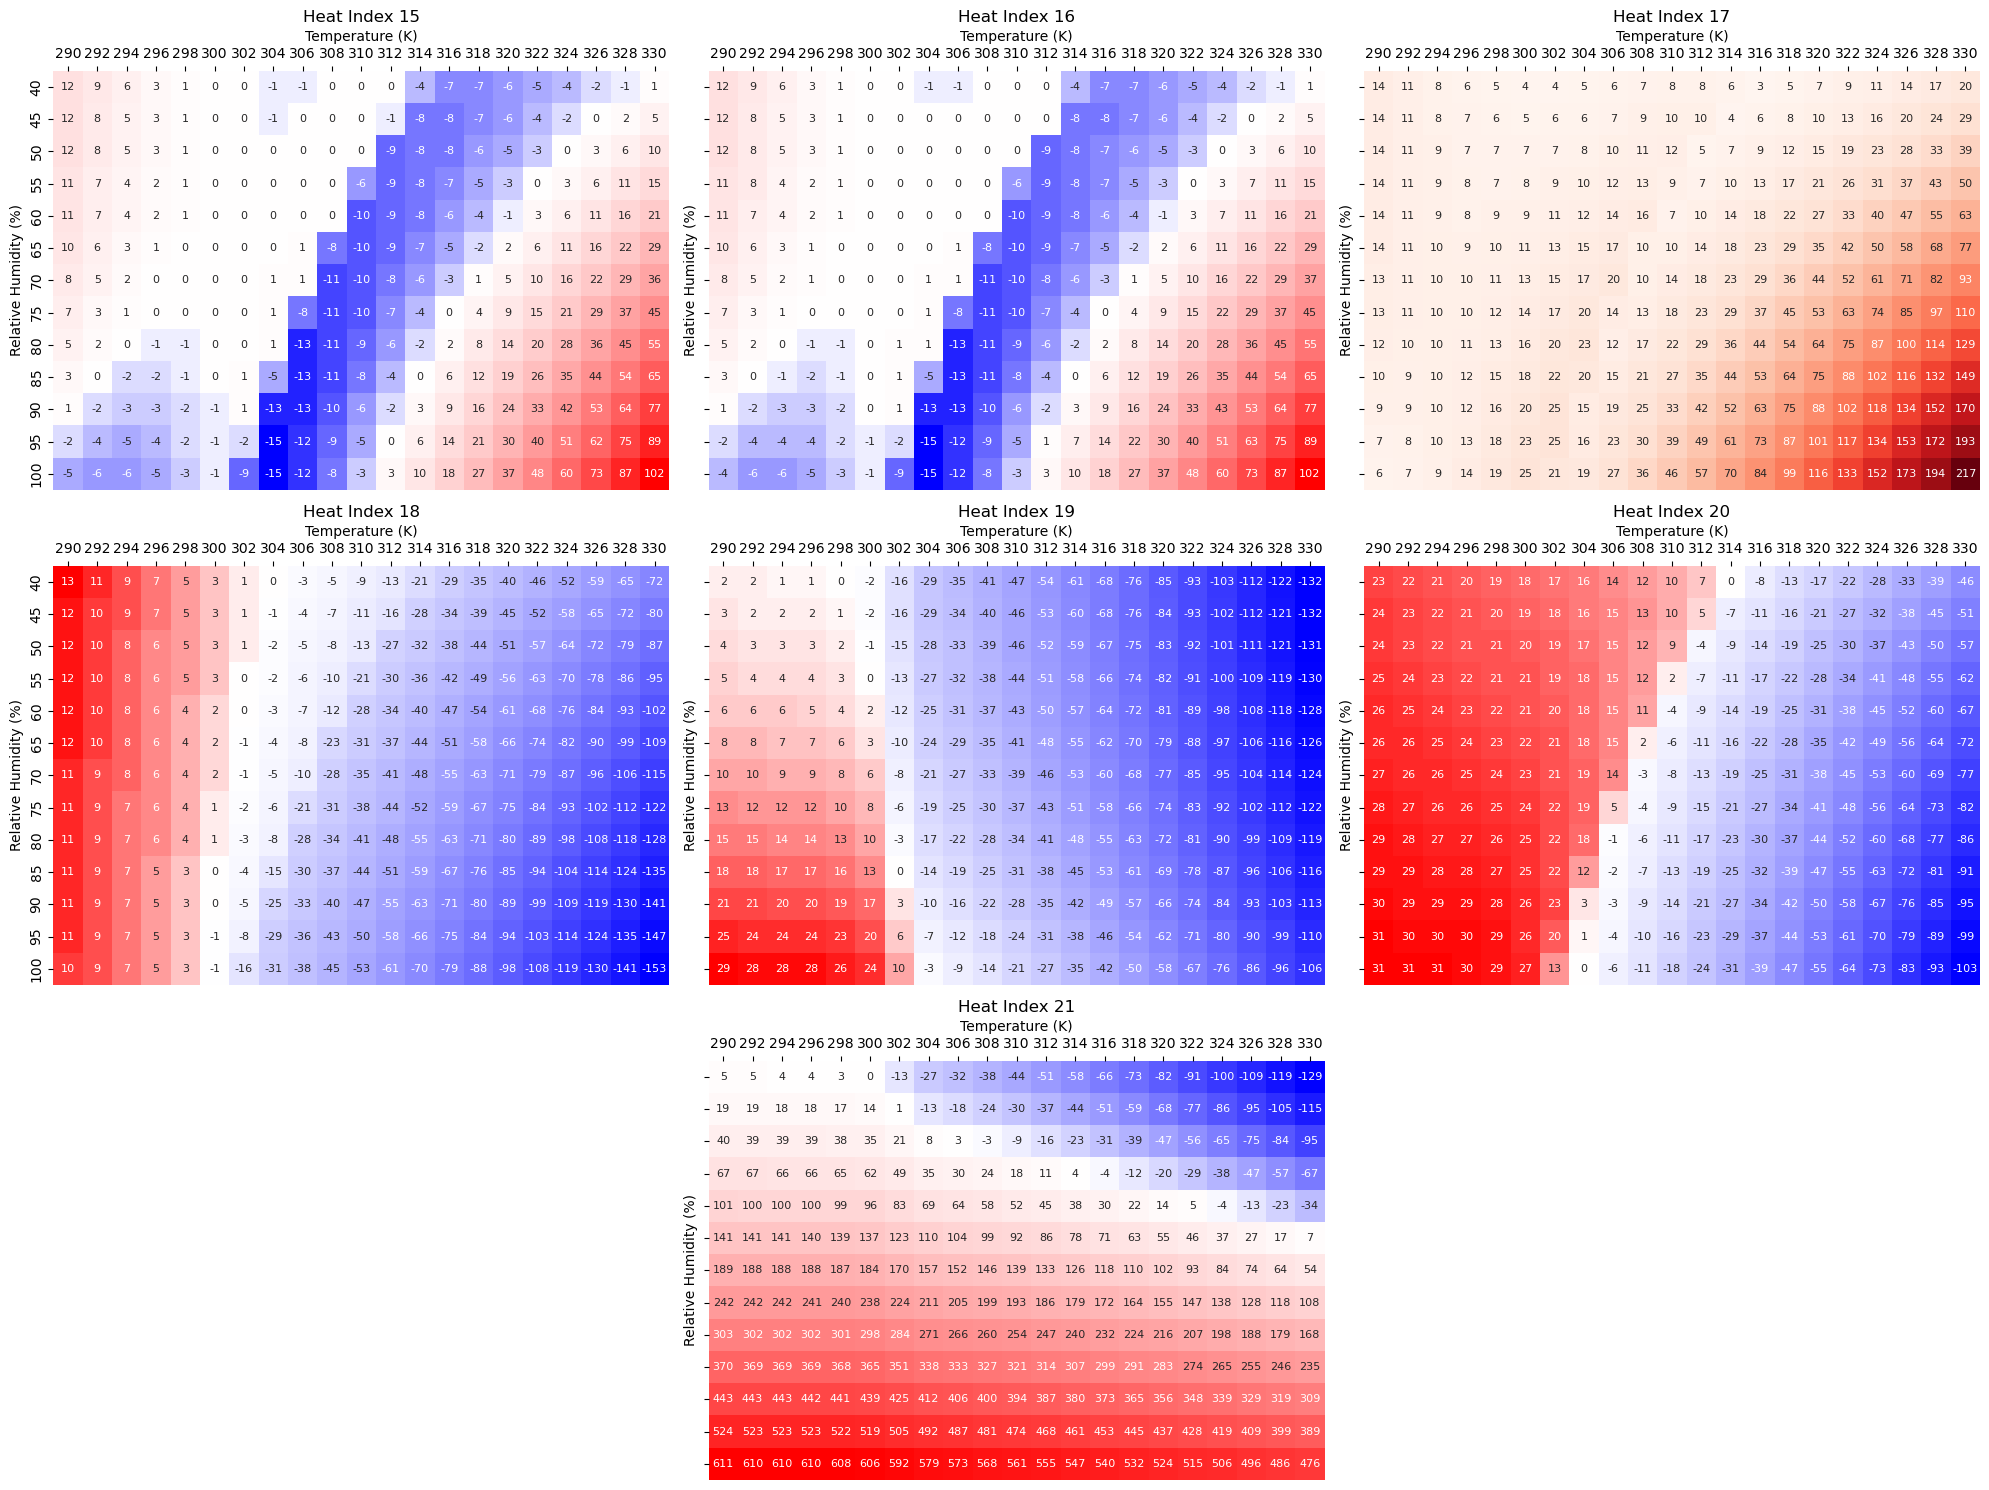

<Figure size 640x480 with 0 Axes>

In [9]:
# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [(0, "b"), (0.5, "white"), (1, "r")])

def create_all_21_heat_indices_tables(tas, rh, td, es):
    output_folder = "heat_index_tables"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    heat_index_functions = [
        heat_index_1, heat_index_2, heat_index_3, heat_index_4, heat_index_5,
        heat_index_6, heat_index_7, heat_index_8, heat_index_9, heat_index_10,
        heat_index_11, heat_index_12, heat_index_13, heat_index_14, heat_index_15,
        heat_index_16, heat_index_17, heat_index_18, heat_index_19, heat_index_20,
        heat_index_21
    ]
    
    # Create the lu_and_romps data table for reference and to use for subtracting for all below heat index tables
    lu_and_romps_data_table = {}
    for temp in tas:
        lu_and_romps_data_table[temp] = {}
        for hum in rh:
            lu_and_romps_data_table[temp][hum] = heatindex(temp, hum/100)
            
    df_lu_and_romps = pd.DataFrame(lu_and_romps_data_table)
    df_lu_and_romps = df_lu_and_romps.round(0)  # Round to 1 decimal place
    df_lu_and_romps.replace(-0.0, 0.0, inplace=True)  # Replace -0 with 0
    df_lu_and_romps.to_csv(f'{output_folder}/heat_index_lu_and_romps.csv')
    print(f'Heat index lu and romps table created, saving as {output_folder}/heat_index_lu_and_romps.csv')

    # Visualize the lu_and_romps data
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(df_lu_and_romps, annot=True, fmt=".0f", cmap=(sns.color_palette("YlOrRd", 10)), cbar=False, cbar_kws={'orientation': 'horizontal'}, annot_kws={"size": 8})
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    plt.title('Heat Index Lu and Romps')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Relative Humidity (%)')
    plt.show()
    
    # Create three figures with subplots
    fig1, axes1 = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
    fig2, axes2 = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
    fig3, axes3 = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
    
    # Flatten axes and swap the 7th subplot with the 8th subplot
    axes1 = axes1.flatten()
    axes2 = axes2.flatten()
    axes3 = axes3.flatten()
    
    # Moving the bottom row subplots to be centered by swapping the position of a used subplot with an unused subplot
    axes1[6], axes1[7] = axes1[7], axes1[6]
    axes2[6], axes2[7] = axes2[7], axes2[6]
    axes3[6], axes3[7] = axes3[7], axes3[6]
    
    # Remove unused subplots (the last two on the bottom row)
    for ax in [axes1[7], axes1[8]]:
        fig1.delaxes(ax)
    for ax in [axes2[7], axes2[8]]:
        fig2.delaxes(ax)
    for ax in [axes3[7], axes3[8]]:
        fig3.delaxes(ax)
    
    # For each algorithm (in order!), run that algorithm on the dataset and subtract the lu_and_romps data from it.
    # Then create a dataframe for the data and save it as a CSV file
    for index, heat_index_function in enumerate(heat_index_functions):
        filename = f'{output_folder}/heat_index_{index+1}.csv'
        print(f'Creating heat index {index+1} table...')
        data = {}
        if index in [0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19]:
            for temp in tas:
                data[temp] = {}
                for hum in rh:
                    result = heat_index_function(temp, hum)
                    data[temp][hum] = result - lu_and_romps_data_table[temp][hum]
        elif index in [1, 2, 11, 12, 13, 18, 20]:
            for temp in tas:
                data[temp] = {}
                for dew_point in td:
                    result = heat_index_function(temp, dew_point)
                    data[temp][dew_point] = result - lu_and_romps_data_table[temp][hum]
        elif index == 3:
            for temp in tas:
                data[temp] = {}
                for vap_pressure in es:
                    result = heat_index_function(temp, vap_pressure)
                    data[temp][vap_pressure] = result - lu_and_romps_data_table[temp][hum]
        else:
            print(f'Index {index} does not match any condition. Skipping creation')
            continue
        
        df = pd.DataFrame(data)
        df = df.round(0)  # Round to 0 decimal places (otherwise doesn't fit!)
        df.replace(-0.0, 0.0, inplace=True)  # Replace -0 with 0 (looks better this way)
        df.to_csv(filename)
        print(f'Heat index {index+1} table created, saving as {filename}')
    
        # Visualize the data
        data_min = df.min().min()
        data_max = df.max().max()
        
        # Apply the colormap and normalization recognising how some plots don't go through 0
        if data_max <= 0:
            cmap = 'Blues'
            norm = mcolors.Normalize(vmin=data_min, vmax=0)
            ticks = np.linspace(data_min, 0, 5)
        elif data_min > 0:
            cmap = 'Reds'
            norm = mcolors.Normalize(vmin=data_min, vmax=data_max)
            ticks = np.linspace(data_min, data_max, 5)
        else: # If the data crosses zero 
            vmin = min(data_min, 0)
            vmax = max(data_max, 0)
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            cmap = custom_cmap
            ticks = np.linspace(data_min, data_max, 5)
        
        # Seperate the subplots into 3 figures, each of 7 heat indices, with the final one of each figure centered in the bottom row
        if index < 7:
            ax = sns.heatmap(df, annot=True, fmt=".0f", cmap=cmap, norm=norm, cbar=False, cbar_kws={'orientation': 'horizontal'}, yticklabels=range(40,105,5), xticklabels=tas, ax=axes1[index], annot_kws={"size": 8})
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_label_position('top')
            ax.set_title(f'Heat Index {index+1}')
            ax.set_xlabel('Temperature (K)')
            ax.set_ylabel('Relative Humidity (%)')
        elif index < 14:
            ax = sns.heatmap(df, annot=True, fmt=".0f", cmap=cmap, norm=norm, cbar=False, cbar_kws={'orientation': 'horizontal'}, yticklabels=range(40,105,5), xticklabels=tas, ax=axes2[index-7], annot_kws={"size": 8})
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_label_position('top')
            ax.set_title(f'Heat Index {index+1}')
            ax.set_xlabel('Temperature (K)')
            ax.set_ylabel('Relative Humidity (%)')
        else:
            ax = sns.heatmap(df, annot=True, fmt=".0f", cmap=cmap, norm=norm, cbar=False, cbar_kws={'orientation': 'horizontal'}, yticklabels=range(40,105,5), xticklabels=tas, ax=axes3[index-14], annot_kws={"size": 8})
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_label_position('top')
            ax.set_title(f'Heat Index {index+1}')
            ax.set_xlabel('Temperature (K)')
            ax.set_ylabel('Relative Humidity (%)')
    
    plt.tight_layout()
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    plt.show()

    plt.savefig(f'{output_folder}/Lu_and_romps_table.png')
    fig1.savefig(f'{output_folder}/heat_indices_tables_1.png')
    fig2.savefig(f'{output_folder}/heat_indices_tables_2.png')
    fig3.savefig(f'{output_folder}/heat_indices_tables_3.png')


create_all_21_heat_indices_tables(tas, rh, td, es)

## Output one plot per algorithm

Heat index lu and romps table created, saving as heat_index_tables/heat_index_lu_and_romps.csv


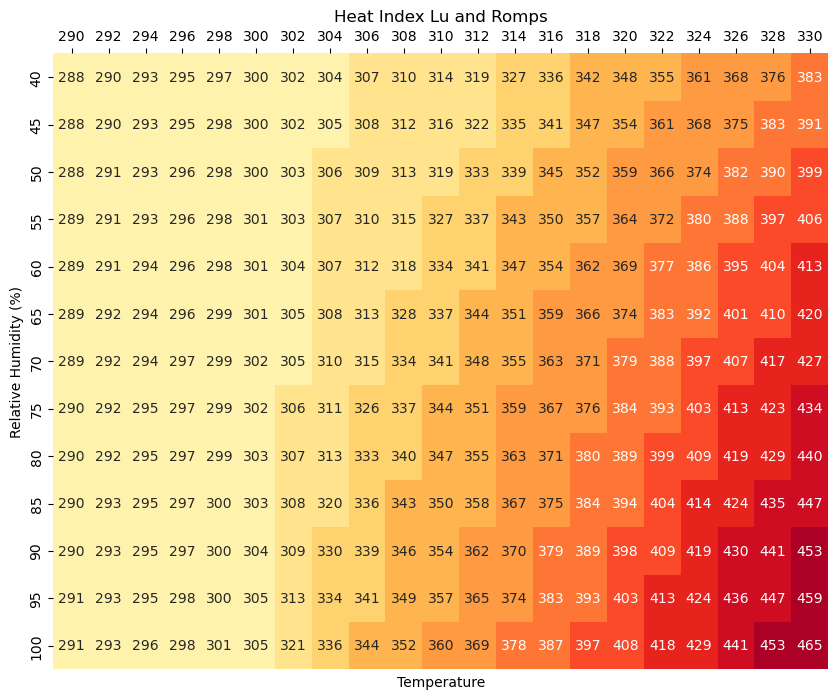

Creating heat index 1 table...
Heat index 1 table created, saving as heat_index_tables/heat_index_1.csv


/var/folders/9v/9sz6tm8n0l7516_drc_ctgyw0000gn/T/ipykernel_9320/1098823624.py:18: RuntimeWarning: invalid value encountered in scalar power
  B - ((13 - rh) / 4) * ((17 - abs((tas - 95))) / 17) ** 0.5,


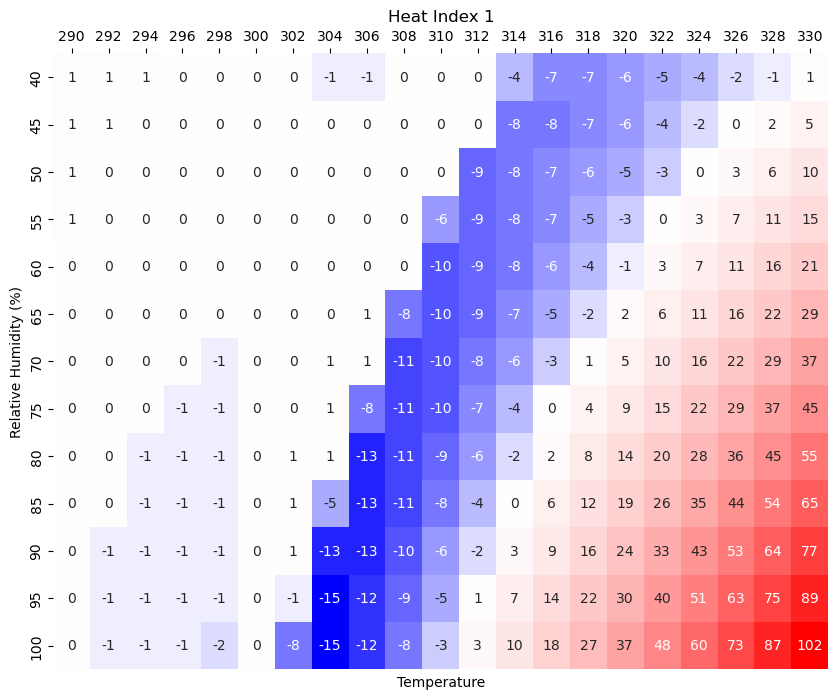

Creating heat index 2 table...
Heat index 2 table created, saving as heat_index_tables/heat_index_2.csv


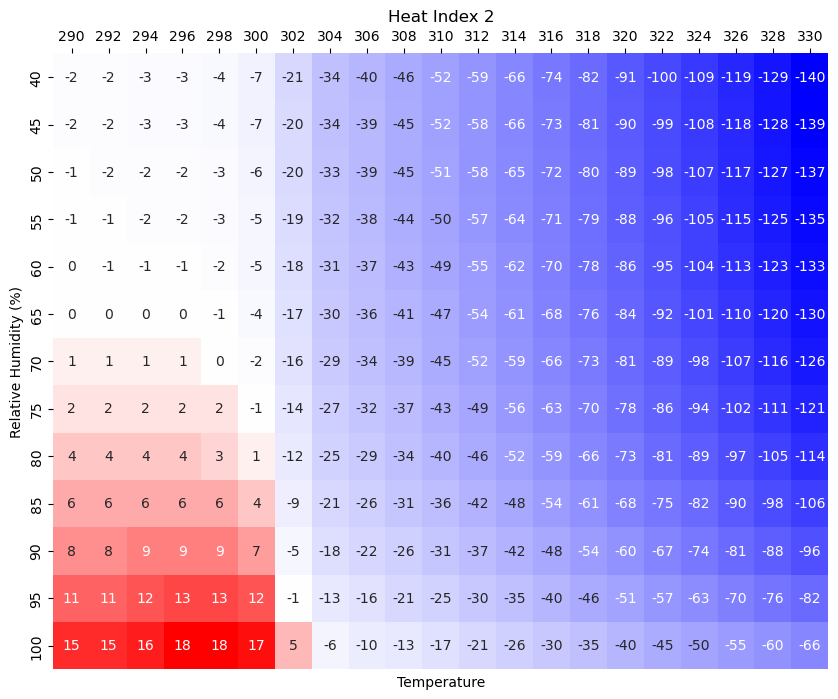

Creating heat index 3 table...
Heat index 3 table created, saving as heat_index_tables/heat_index_3.csv


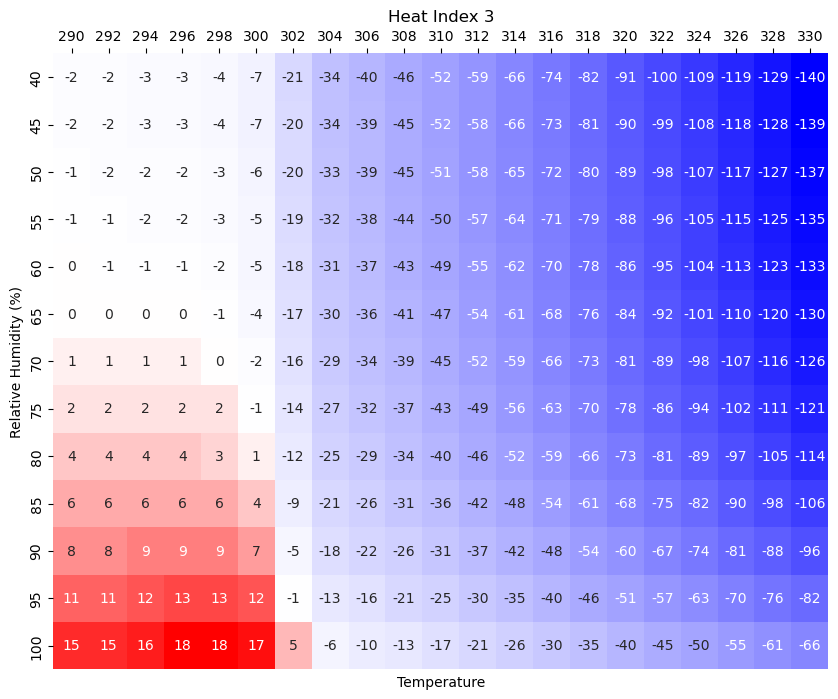

Creating heat index 4 table...
Heat index 4 table created, saving as heat_index_tables/heat_index_4.csv


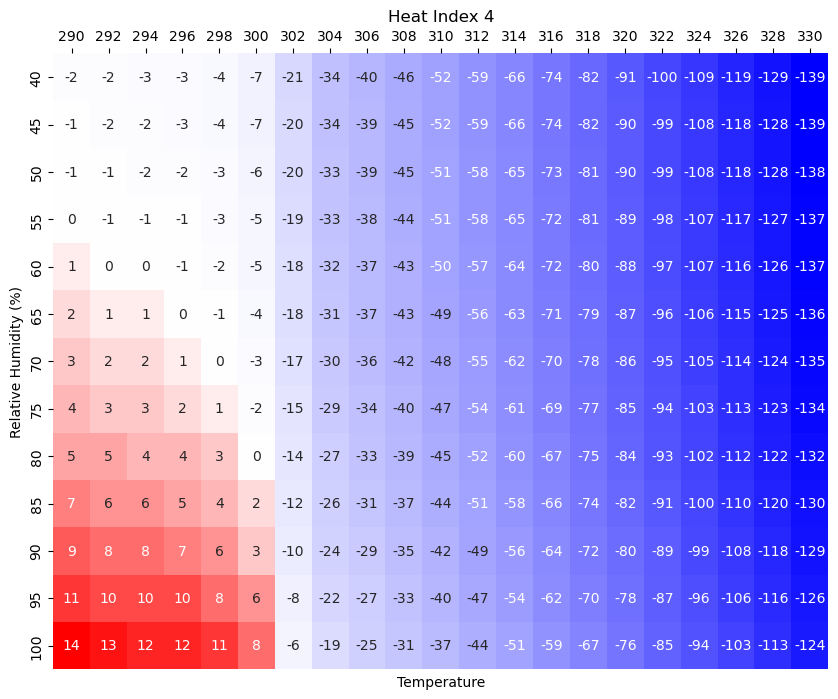

Creating heat index 5 table...
Heat index 5 table created, saving as heat_index_tables/heat_index_5.csv


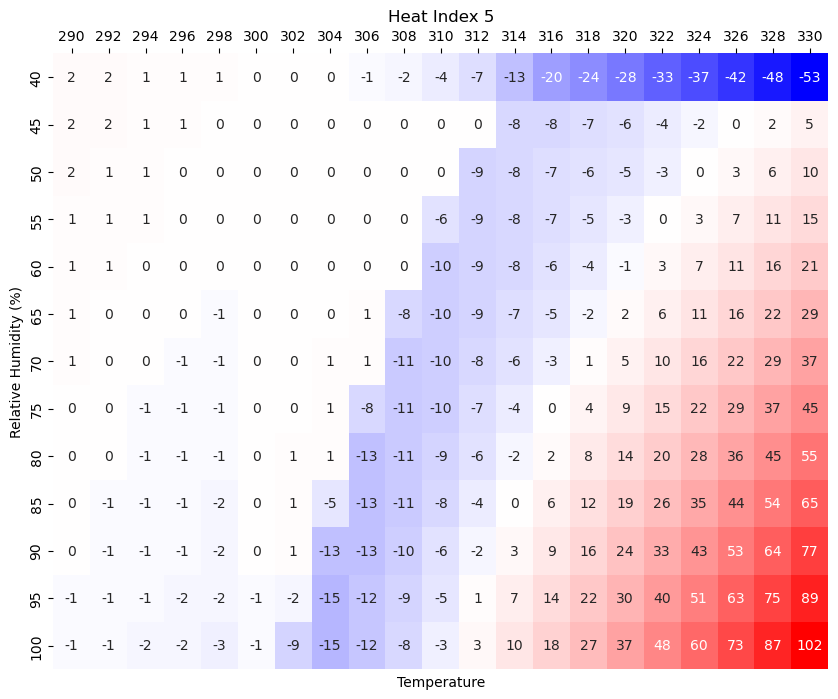

Creating heat index 6 table...
Heat index 6 table created, saving as heat_index_tables/heat_index_6.csv


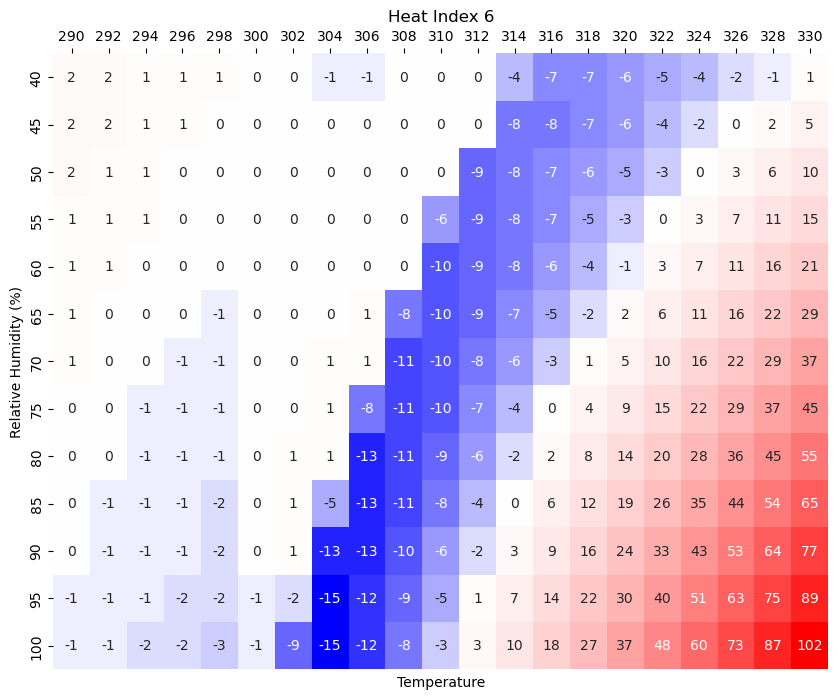

Creating heat index 7 table...
Heat index 7 table created, saving as heat_index_tables/heat_index_7.csv


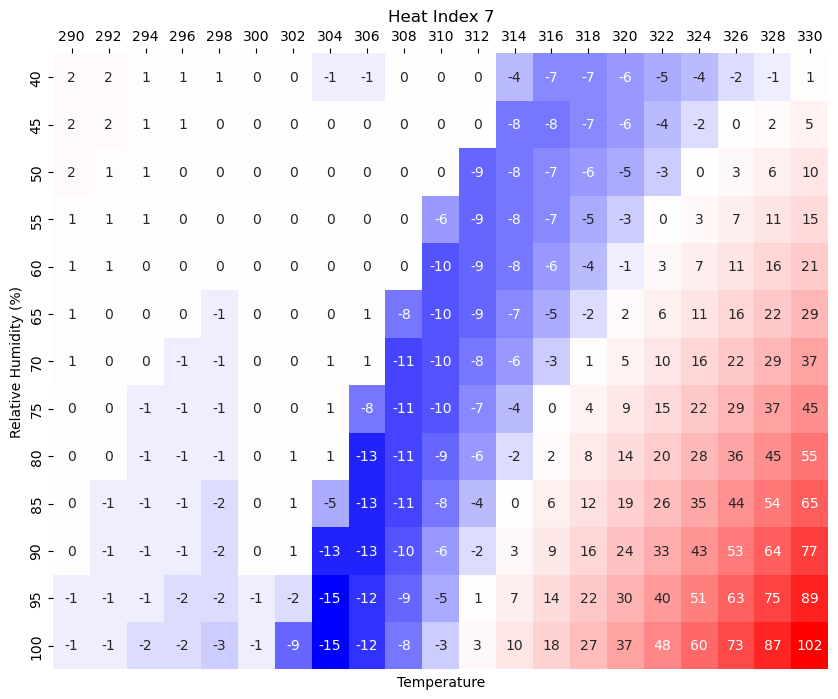

Creating heat index 8 table...
Heat index 8 table created, saving as heat_index_tables/heat_index_8.csv


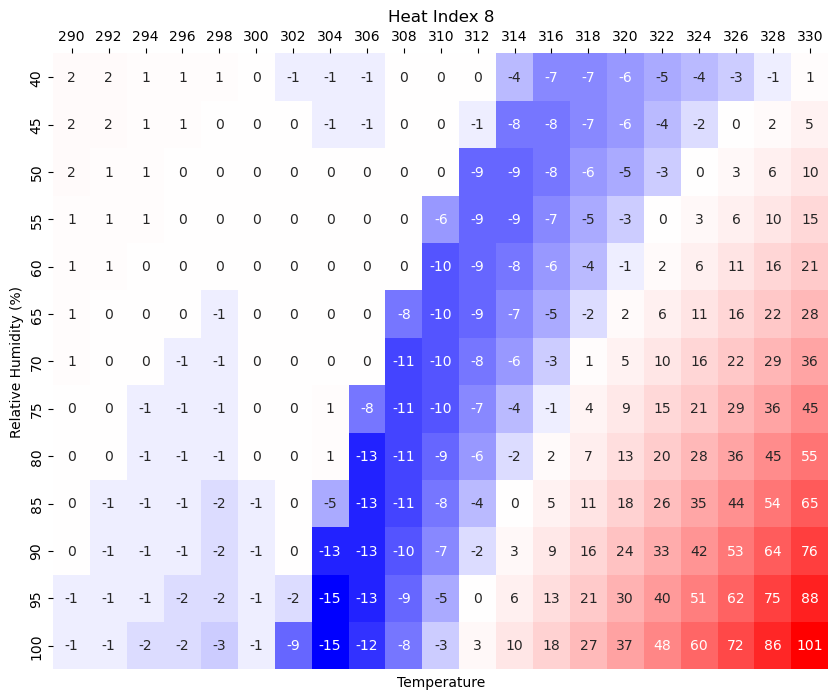

Creating heat index 9 table...
Heat index 9 table created, saving as heat_index_tables/heat_index_9.csv


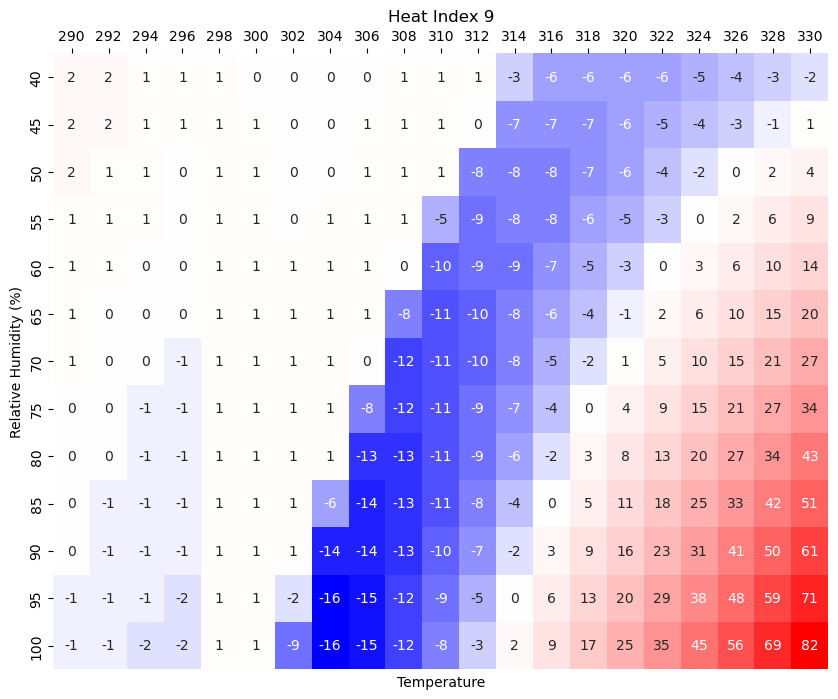

Creating heat index 10 table...
Heat index 10 table created, saving as heat_index_tables/heat_index_10.csv


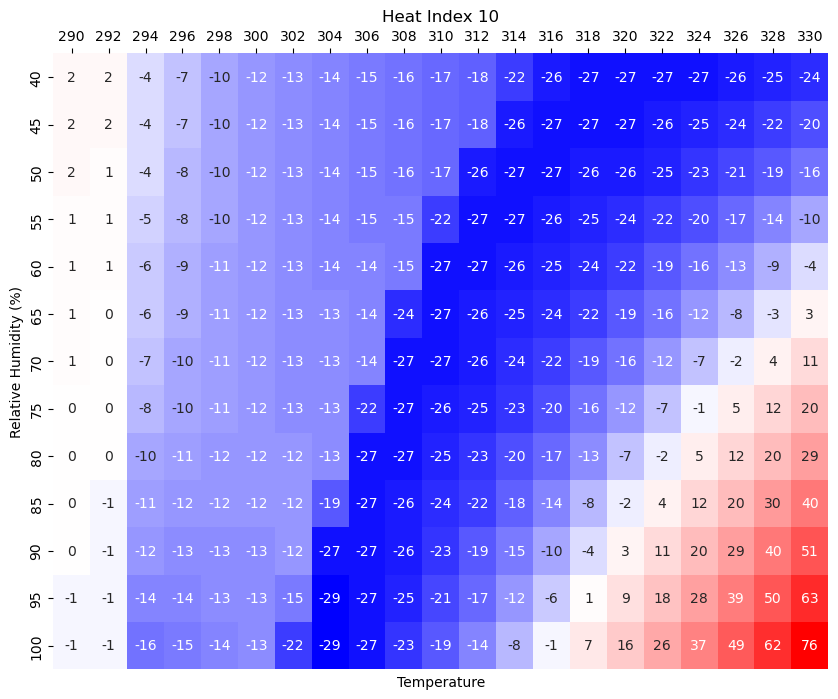

Creating heat index 11 table...
Heat index 11 table created, saving as heat_index_tables/heat_index_11.csv


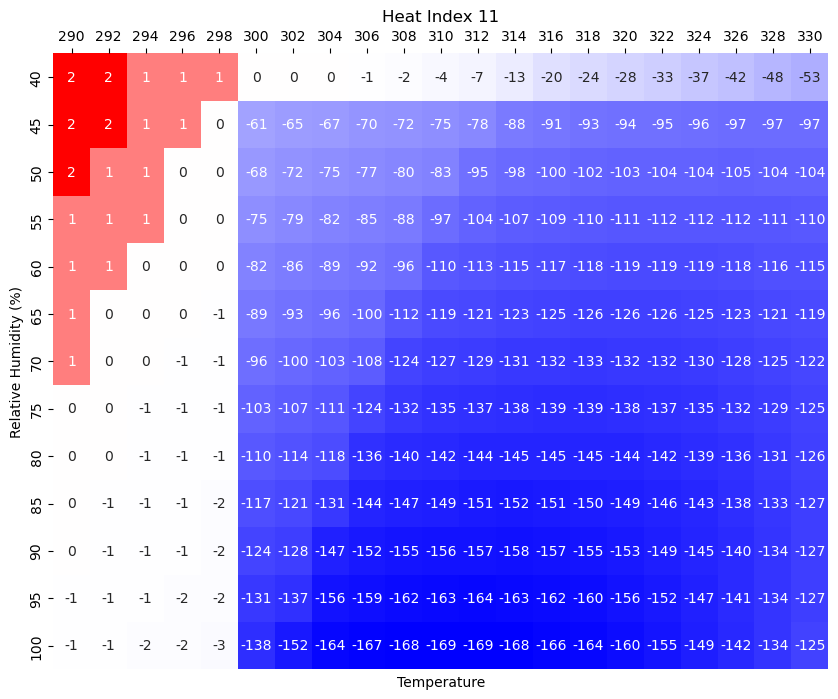

Creating heat index 12 table...
Heat index 12 table created, saving as heat_index_tables/heat_index_12.csv


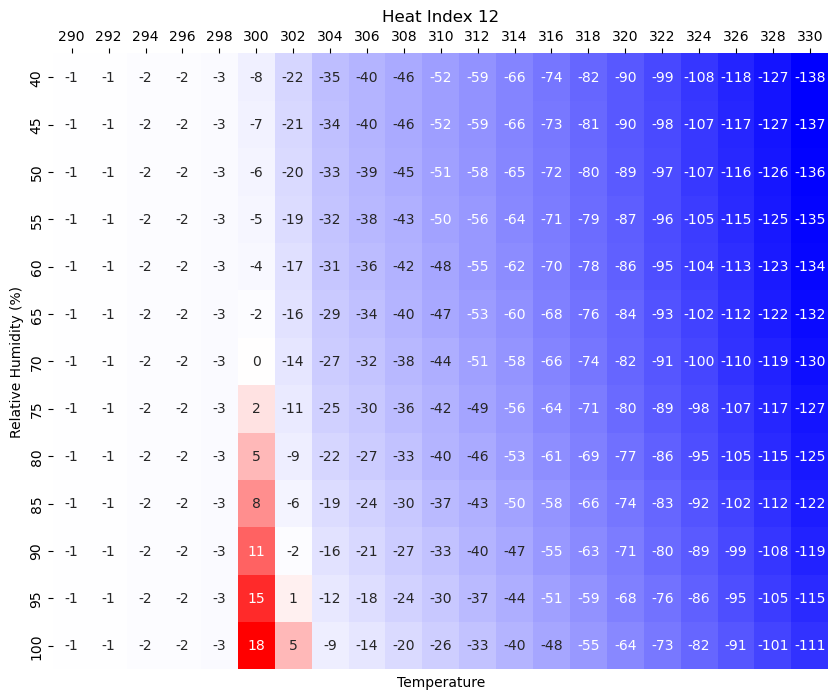

Creating heat index 13 table...
Heat index 13 table created, saving as heat_index_tables/heat_index_13.csv


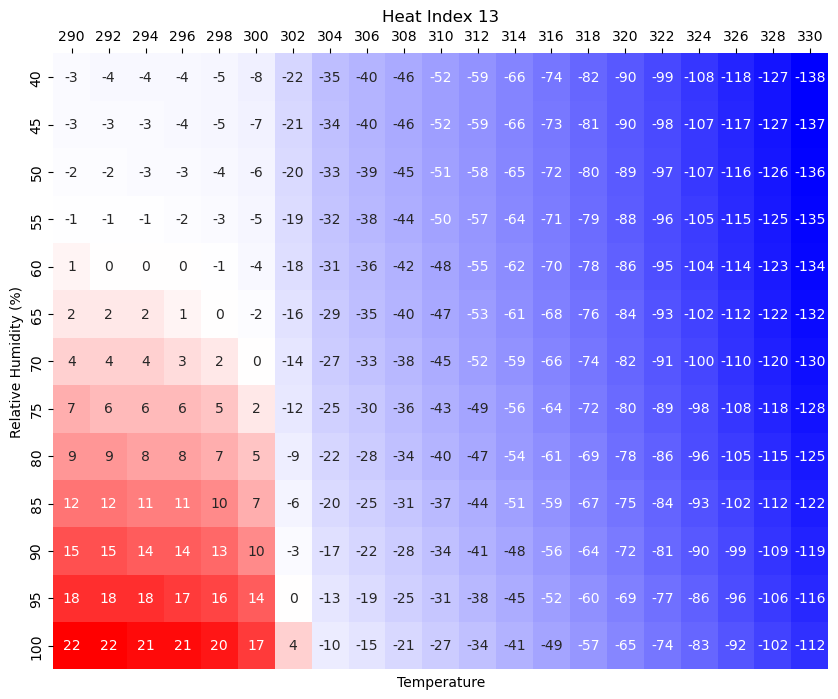

Creating heat index 14 table...
Heat index 14 table created, saving as heat_index_tables/heat_index_14.csv


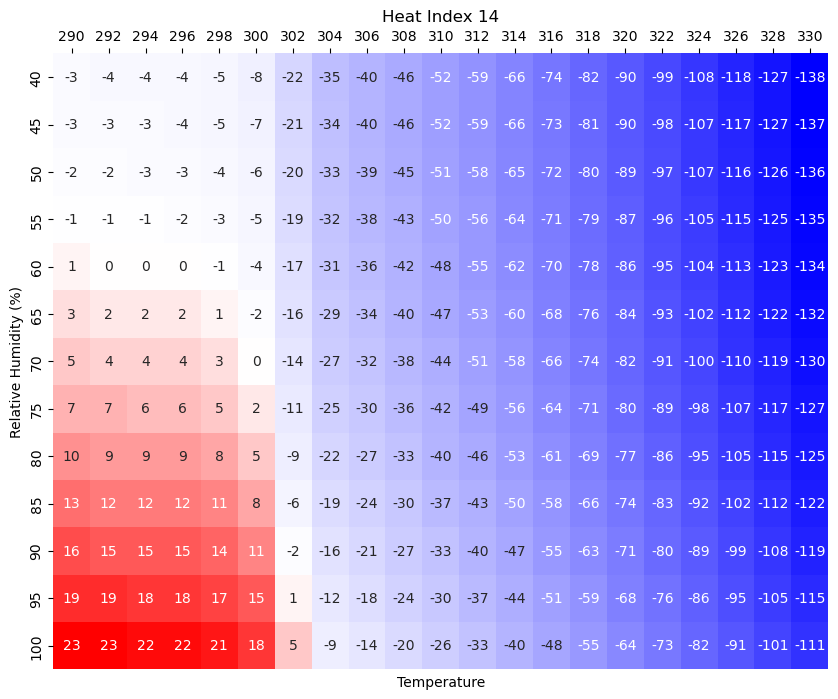

Creating heat index 15 table...
Heat index 15 table created, saving as heat_index_tables/heat_index_15.csv


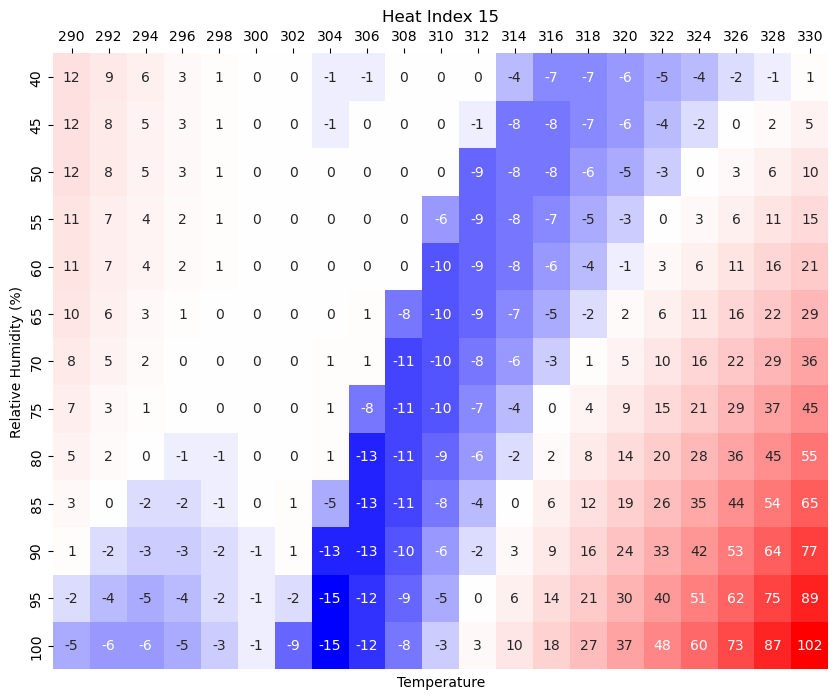

Creating heat index 16 table...
Heat index 16 table created, saving as heat_index_tables/heat_index_16.csv


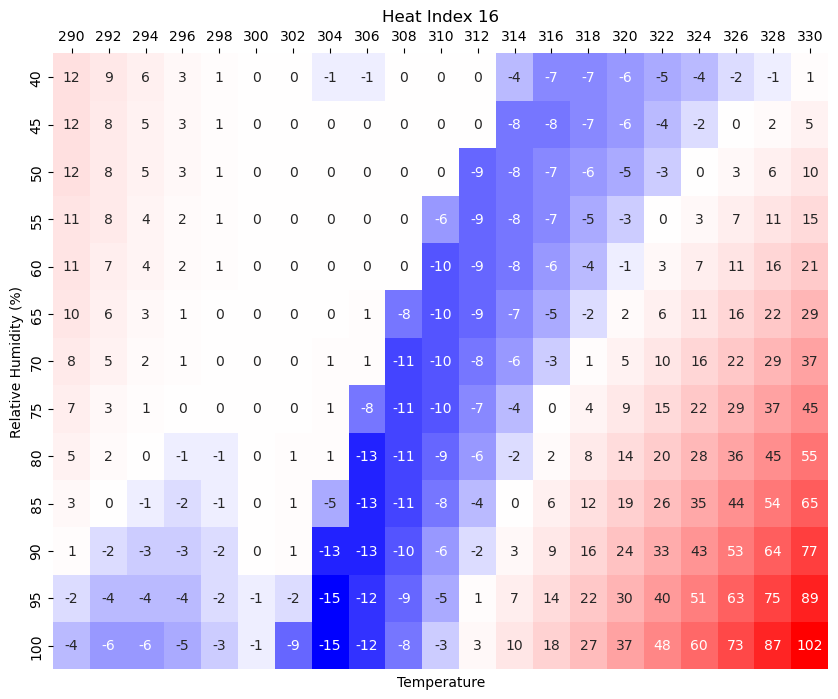

Creating heat index 17 table...
Heat index 17 table created, saving as heat_index_tables/heat_index_17.csv


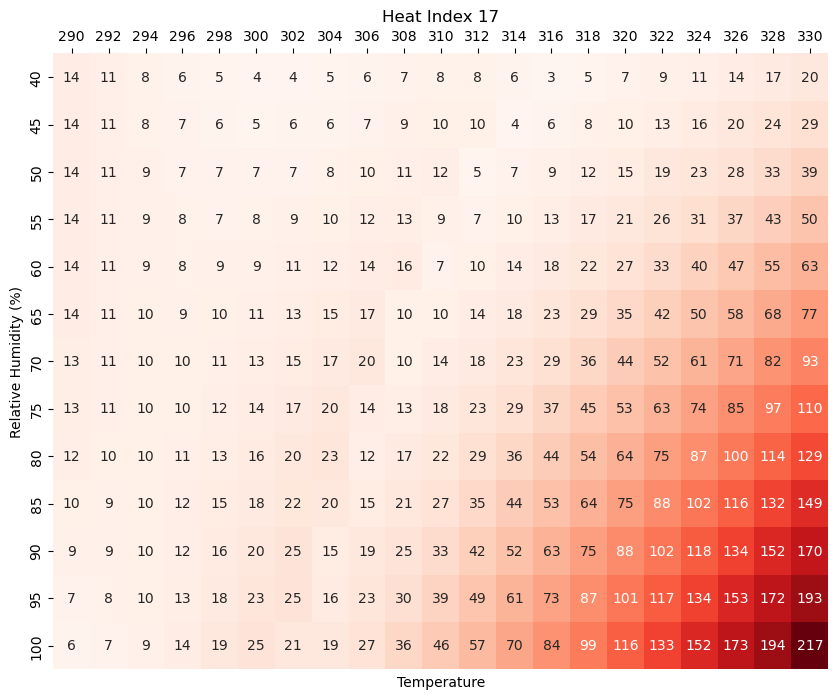

Creating heat index 18 table...
Heat index 18 table created, saving as heat_index_tables/heat_index_18.csv


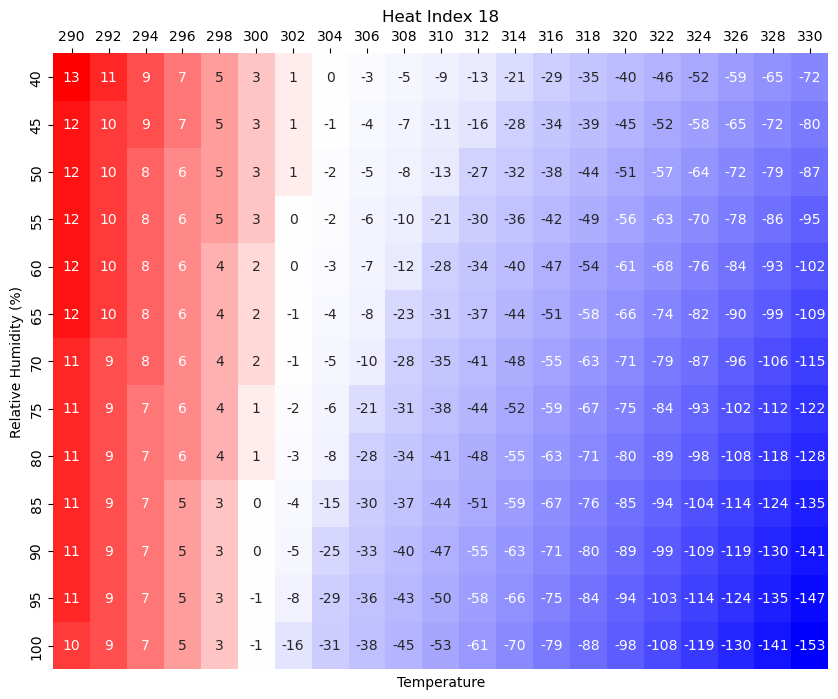

Creating heat index 19 table...
Heat index 19 table created, saving as heat_index_tables/heat_index_19.csv


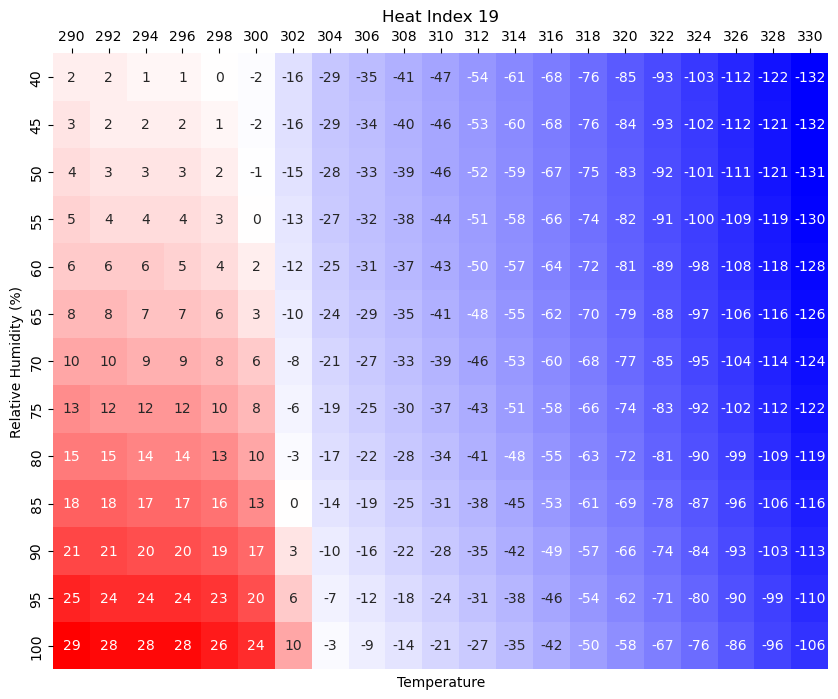

Creating heat index 20 table...
Heat index 20 table created, saving as heat_index_tables/heat_index_20.csv


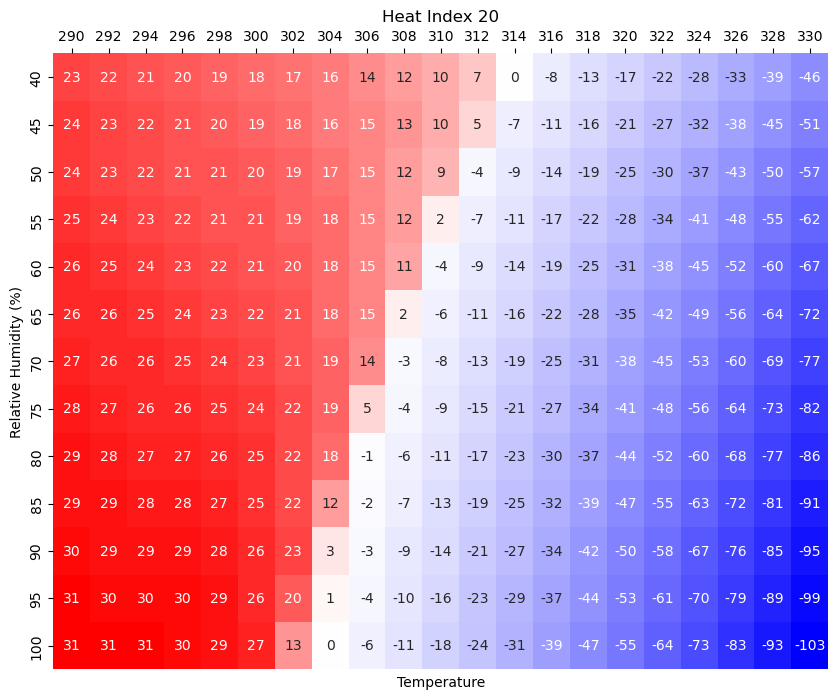

Creating heat index 21 table...
Heat index 21 table created, saving as heat_index_tables/heat_index_21.csv


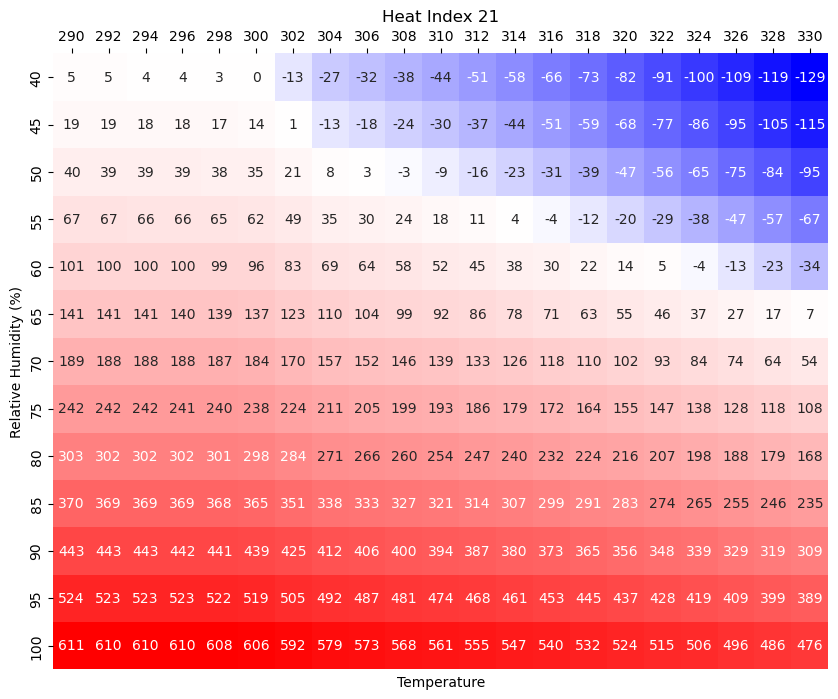

In [11]:
# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [(0, "blue"), (0.5, "white"), (1, "red")])

def create_all_21_heat_indices_tables(tas, rh, td, es):
    output_folder = "heat_index_tables"
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    heat_index_functions = [
        heat_index_1, heat_index_2, heat_index_3, heat_index_4, heat_index_5,
        heat_index_6, heat_index_7, heat_index_8, heat_index_9, heat_index_10,
        heat_index_11, heat_index_12, heat_index_13, heat_index_14, heat_index_15,
        heat_index_16, heat_index_17, heat_index_18, heat_index_19, heat_index_20,
        heat_index_21
    ]
    
    # Creating the lu_and_romps data table for reference and to use for subtracting for all below heat index tables
    lu_and_romps_data_table = {}
    for temp in tas:
        lu_and_romps_data_table[temp] = {}
        for hum in rh:
            lu_and_romps_data_table[temp][hum] = heatindex(temp, hum/100)
            
    df_lu_and_romps = pd.DataFrame(lu_and_romps_data_table)
    df_lu_and_romps = df_lu_and_romps.round(0) # Round to 0 decimal places (otherwise doesn't fit!) 
    df_lu_and_romps.replace(-0.0, 0.0, inplace=True) # Replace -0 with 0 (looks better this way)
    df_lu_and_romps.to_csv(f'{output_folder}/heat_index_lu_and_romps.csv')
    print(f'Heat index lu and romps table created, saving as {output_folder}/heat_index_lu_and_romps.csv')

    # Visualize the lu_and_romps data
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(df_lu_and_romps, annot=True, fmt=".0f", cmap=(sns.color_palette("YlOrRd", 10)), cbar=False, cbar_kws={'orientation': 'horizontal'})
    ax.xaxis.set_ticks_position('top')
    
    plt.title('Heat Index Lu and Romps')
    plt.xlabel('Temperature')
    plt.ylabel('Relative Humidity (%)')
    plt.show()
    
    # For each algorithm (in order!), run that algorithm on the dataset and subtract the lu_and_romps data from it.
    # Then create a dataframe for the data and save it as a CSV file
    for index, heat_index_function in enumerate(heat_index_functions):
        filename = f'{output_folder}/heat_index_{index+1}.csv'
        if not os.path.exists(filename):
            print(f'Creating heat index {index+1} table...')
            data = {}
            if index in [0, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19]:
                for temp in tas:
                    data[temp] = {}
                    for hum in rh:
                        result = heat_index_function(temp, hum)
                        data[temp][hum] = result - lu_and_romps_data_table[temp][hum]
            elif index in [1, 2, 11, 12, 13, 18, 20]:
                for temp in tas:
                    data[temp] = {}
                    for dew_point in td:
                        result = heat_index_function(temp, dew_point)
                        data[temp][dew_point] = result - lu_and_romps_data_table[temp][hum]
            elif index == 3:
                for temp in tas:
                    data[temp] = {}
                    for vap_pressure in es:
                        result = heat_index_function(temp, vap_pressure)
                        data[temp][vap_pressure] = result - lu_and_romps_data_table[temp][hum]
            else:
                print(f'Index {index} does not match any condition. Skipping creation')
                continue
            
            df = pd.DataFrame(data)
            df = df.round(0)  # Round to 0 decimal places
            df.replace(-0.0, 0.0, inplace=True)  # Replace -0 with 0
            df.to_csv(filename)
            print(f'Heat index {index+1} table created, saving as {filename}')
        
            # Visualize the data
            plt.figure(figsize=(10, 8))
            data_min = df.min().min()
            data_max = df.max().max()
            
            # Apply the colormap and normalization recognising how some plots don't go through 0
            if data_max <= 0:
                cmap = 'Blues'
                norm = mcolors.Normalize(vmin=data_min, vmax=0)
                ticks = np.linspace(data_min, 0, 5)
            elif data_min > 0:
                cmap = 'Reds'
                norm = mcolors.Normalize(vmin=data_min, vmax=data_max)
                ticks = np.linspace(data_min, data_max, 5)
            else: # If the data crosses zero 
                vmin = min(data_min, 0)
                vmax = max(data_max, 0)
                norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
                cmap = custom_cmap
                ticks = np.linspace(data_min, data_max, 5)
            
            ax = sns.heatmap(df, annot=True, fmt=".0f", cmap=cmap, norm=norm, cbar=False, cbar_kws={'orientation': 'horizontal'}, yticklabels=range(40,105,5))
            ax.xaxis.set_ticks_position('top')
            plt.title(f'Heat Index {index+1}')
            plt.xlabel('Temperature')
            plt.ylabel('Relative Humidity (%)')
            plt.show()
        else:
            print(f'Heat index {index+1} table already exists, skipping.')

create_all_21_heat_indices_tables(tas, rh, td, es)